🚀 Iniciando evaluación del modelo K-Means...

📉 Aplicando PCA con 8 componentes...

🔁 Entrenando K-Means con k = 10...

📊 Métricas de evaluación:
- Inercia (SSE): 18040.76
- Silhouette Score: 0.1504
- Davies-Bouldin Index: 1.6630
- Homogeneidad: 0.5469
- Completitud: 0.1686
- V-Measure: 0.2578
- Dunn Index: 0.0279

📌 Visualizando clusters con PCA...


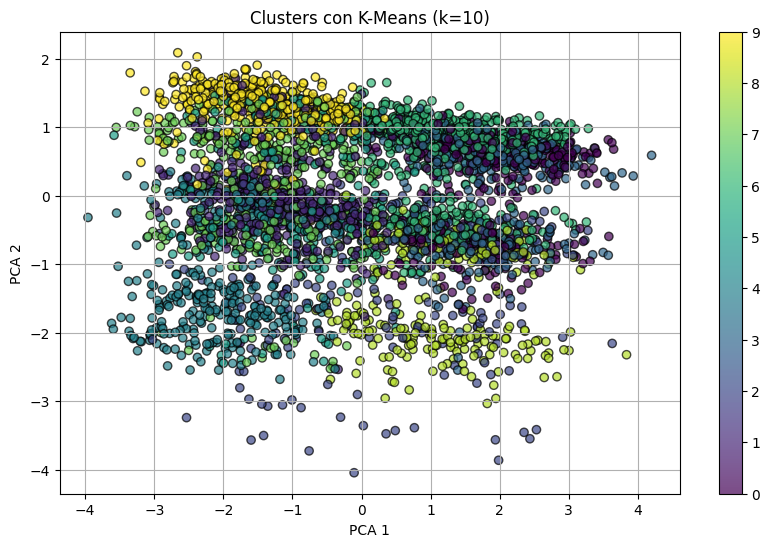


🧩 Tabla cruzada entre clústeres y enfermedad:
HeartDisease    0    1
Cluster               
0             360   17
1              52  377
2             105   80
3             424   17
4              26  367
5              46  209
6             597   87
7              31  398
8             238   34
9              31  422

📌 Media de características por clúster:
               Age  Cholesterol   RestingBP       MaxHR   Oldpeak
Cluster                                                          
0        53.586207   233.411141  128.702918  149.358090  0.364403
1        56.951049   272.251748  130.846154  134.566434  1.458718
2        52.340541   220.064865  132.762162  141.659459  0.764324
3        48.922902   229.535147  132.185941  150.947846  0.388730
4        56.801527   171.145038  140.964377  121.458015  1.268702
5        56.223529   165.776471  131.984314  131.074510  1.196667
6        47.678363   228.631579  130.703216  148.893275  0.277909
7        56.130536    81.233100  124.57109

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score,
    homogeneity_score, completeness_score, v_measure_score
)
from sklearn.metrics.pairwise import pairwise_distances

# --- Cargar y preparar los datos ---
df = pd.read_csv('heart_data_aumentado.csv')
# df = pd.get_dummies(
#     df,
#     columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'],
#     drop_first=True
# )

# --- Definición de métricas ---
def dunn_index(X, labels):
    unique_labels = np.unique(labels)
    inter_cluster_distances = []
    intra_cluster_distances = []

    for i in unique_labels:
        for j in unique_labels:
            if i != j:
                dist = np.min(pairwise_distances(X[labels == i], X[labels == j]))
                inter_cluster_distances.append(dist)

    for i in unique_labels:
        dist = np.max(pairwise_distances(X[labels == i]))
        intra_cluster_distances.append(dist)

    return np.min(inter_cluster_distances) / np.max(intra_cluster_distances)

# --- Evaluación del modelo ---
def evaluar_modelo_kmeans(df, etiqueta='HeartDisease', k=3, use_pca=True, pca_components=10, use_minibatch=True):
    print("🚀 Iniciando evaluación del modelo K-Means...\n")

    # 1. Separar datos
    X = df.drop(columns=[etiqueta])
    y = df[etiqueta]

    # 2. Escalado
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 3. PCA (opcional)
    if use_pca:
        print(f"📉 Aplicando PCA con {pca_components} componentes...")
        pca = PCA(n_components=pca_components)
        X_scaled = pca.fit_transform(X_scaled)

    # 4. Entrenamiento
    print(f"\n🔁 Entrenando K-Means con k = {k}...")
    model = MiniBatchKMeans(n_clusters=k, random_state=42, n_init=50, batch_size=128) if use_minibatch \
            else KMeans(n_clusters=k, random_state=42, n_init=50)

    clusters = model.fit_predict(X_scaled)

    # 5. Evaluación
    print("\n📊 Métricas de evaluación:")
    print(f"- Inercia (SSE): {model.inertia_:.2f}")
    print(f"- Silhouette Score: {silhouette_score(X_scaled, clusters):.4f}")
    print(f"- Davies-Bouldin Index: {davies_bouldin_score(X_scaled, clusters):.4f}")
    print(f"- Homogeneidad: {homogeneity_score(y, clusters):.4f}")
    print(f"- Completitud: {completeness_score(y, clusters):.4f}")
    print(f"- V-Measure: {v_measure_score(y, clusters):.4f}")
    print(f"- Dunn Index: {dunn_index(X_scaled, clusters):.4f}")

    # 6. Visualización
    print("\n📌 Visualizando clusters con PCA...")
    pca_vis = PCA(n_components=2)
    reduced_data = pca_vis.fit_transform(X_scaled)

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', alpha=0.7, edgecolors='k')
    plt.title(f"Clusters con K-Means (k={k})")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.colorbar(scatter)
    plt.grid(True)
    plt.show()

    # 7. Análisis cruzado con etiqueta real
    comparison_df = pd.DataFrame({
        'Cluster': clusters,
        'HeartDisease': y
    })
    print("\n🧩 Tabla cruzada entre clústeres y enfermedad:")
    print(pd.crosstab(comparison_df['Cluster'], comparison_df['HeartDisease']))

    return {
        'modelo': model,
        'clusters': clusters,
        'X_scaled': X_scaled,
        'etiquetas_reales': y
    }

# --- Ejecutar evaluación ---
resultado = evaluar_modelo_kmeans(
    df,
    etiqueta='HeartDisease',
    k=10,  # probar primero con 3 (enfermos, no enfermos, y un tercer grupo)
    use_pca=True,
    pca_components=8,
    use_minibatch=True
)

df_clusters = df.copy()
df_clusters['Cluster'] = resultado['clusters']

print("\n📌 Media de características por clúster:")
print(df_clusters.groupby('Cluster').mean()[['Age', 'Cholesterol', 'RestingBP', 'MaxHR', 'Oldpeak']])

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Cargar y analizar dataset original
df = pd.read_csv('heart_data_aumentado.csv')
# df = pd.get_dummies(df, columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], drop_first=True)

# Separar por clase para simular pacientes sanos y con enfermedad por separado
df_sano = df[df['HeartDisease'] == 0]
df_enfermo = df[df['HeartDisease'] == 1]

def generar_sinteticos_mejorado(df_base, n=500):
    """
    Genera datos sintéticos realistas respetando los tipos de variable.
    """
    df_out = pd.DataFrame()

    for col in df_base.columns:
        valores_unicos = df_base[col].nunique()

        if valores_unicos == 2 and df_base[col].dropna().isin([0, 1]).all():
            # Binaria
            p = df_base[col].mean()
            df_out[col] = np.random.binomial(1, p, n).astype(int)

        elif col in ['Age', 'RestingBP', 'MaxHR', 'Cholesterol']:
            # Numéricas enteras
            mu = df_base[col].mean()
            sigma = df_base[col].std()
            df_out[col] = np.random.normal(mu, sigma, n).clip(df_base[col].min(), df_base[col].max()).round().astype(int)

        elif col == 'Oldpeak':
            # Decimal controlado
            mu = df_base[col].mean()
            sigma = df_base[col].std()
            df_out[col] = np.random.normal(mu, sigma, n).clip(df_base[col].min(), df_base[col].max()).round(2)

        else:
            # Cualquier otra continua → como float, por defecto
            mu = df_base[col].mean()
            sigma = df_base[col].std()
            df_out[col] = np.random.normal(mu, sigma, n).clip(df_base[col].min(), df_base[col].max())

    return df_out

# Generar 500 sanos y 500 enfermos
sanos_fake = generar_sinteticos_mejorado(df_sano.drop(columns='HeartDisease'), n=500)
enfermos_fake = generar_sinteticos_mejorado(df_enfermo.drop(columns='HeartDisease'), n=500)

sanos_fake['HeartDisease'] = 0
enfermos_fake['HeartDisease'] = 1

# Concatenar y mezclar
df_sintetico = pd.concat([sanos_fake, enfermos_fake], ignore_index=True)
df_final = pd.concat([df, df_sintetico], ignore_index=True)
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Número de muestras originales: {df.shape[0]}")
print(f"Número de muestras después de aumentar: {df_final.shape[0]}")

# Guardar si quieres
df_final.to_csv("heart_data_aumentado.csv", index=False)

Número de muestras originales: 2918
Número de muestras después de aumentar: 3918
